# Synthetic Catalogue of Optical Transients and Correlated Hosts (SCOTCH) Tutorials 

This file is meant to serve as a series of walkthroughs for using the SCOTCH catalog. These examples are minimal, but should provide enough to get up and running with the data. Questions should be directed to m.lokken@mail.utoronto.ca and gaglian2@illinois.edu.

### 0. Reading the data. 

As with all tutorials, we'll start by importing the packages we need and the SCOTCH catalogue itself (which is available on zenodo at this link: ). The catalog is an hdf5 file, and about 1.0 GB in size. 

In [1]:
import h5py 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib as mpl
import re 
import astropy.coordinates as coord
import astropy.units as u
import optax
from pzflow import Flow
from scipy import interpolate

scotch = h5py.File("path_to_scotch_catalogue/scotch_z3.hdf5", "r")

And how many transients of each class do we have in the catalogue? 

In [2]:
from collections import Counter
fullCount = 0
for key in list(scotch['TransientTable'].keys()):
    for key2 in list(scotch['TransientTable'][key].keys()):
        Nclass = len(scotch['TransientTable'][key][key2]['GID'][:])
        fullCount += Nclass
        print("%i %s events in the catalogue." %( Nclass, key2))
print("Total Number of Transients:")
print(fullCount)

10000 AGN01 events in the catalogue.
90000 AGN20 events in the catalogue.
50000 KN_B19 events in the catalogue.
50000 KN_K17 events in the catalogue.
100000 SLSN-I events in the catalogue.
633000 SNII+HostXT_V19 events in the catalogue.
633000 SNII-NMF events in the catalogue.
633000 SNII-Templates events in the catalogue.
50000 SNIIn+HostXT_V19 events in the catalogue.
50000 SNIIn-MOSFIT events in the catalogue.
100000 SNIIb+HostXT_V19 events in the catalogue.
100000 SNIa-91bg events in the catalogue.
2000000 SNIa-SALT2 events in the catalogue.
100000 SNIax events in the catalogue.
50000 SNIb+HostXT_V19 events in the catalogue.
50000 SNIb-Templates events in the catalogue.
50000 SNIc+HostXT_V19 events in the catalogue.
50000 SNIc-Templates events in the catalogue.
100000 SNIcBL+HostXT_V19 events in the catalogue.
101000 TDE events in the catalogue.
Total Number of Transients:
5000000


The catalogue contains two tables: one focusing on the properties of simulated optical transients, and one focusing on the properties of their hosts. 

In [3]:
print(scotch.keys())

<KeysViewHDF5 ['HostTable', 'TransientTable']>


Each table is broken down into the transient classes simulated. The first walkthrough will provide an example for how to retrieve properties of the host galaxies of different classes from the `HostTable`. 

## 1. Properties of Transient Host Galaxies

First, let's print the available transient classes in the host galaxy table: 

In [6]:
scotch_hosts = scotch['HostTable']
print(scotch_hosts.keys())

<KeysViewHDF5 ['AGN', 'KN', 'SLSN-I', 'SNII', 'SNIIb', 'SNIa', 'SNIb', 'SNIc', 'TDE']>


Next, let's look at the properties available for each host galaxy of a single class:

A description of each of these properties is given in our paper. Note that `dc2ID` corrresponds to the galaxy's ID in the CosmoDC2 catalog. This ID can be used to query GCRCatalogs and recover additional properties of these galaxies. A word of caution, though, that some of these properties have been changed between CosmoDC2 and their inclusion in SCOTCH. The largest modifications are: 

* **The photometry is adjusted if a galaxy is repeated in the catalogue.** This is done to prevent artifacts that a classifier could pick up on to prevent it from reporting overly optimistic results.
* **The redshifts are adjusted using PZFlow (see publication for details).** We have slightly shifted all true redshifts to remove artifacts that arose in the SED modeling of CosmoDC2 galaxies. This issue affects both observed (photometry) and derived (SFR) properties, but is most prominent as a function of redshift. 
* **Shape parameters (semi-major axis, semi-minor axis, and ellipticity) have been re-calculated.** The values reported in CosmoDC2 used an incorrect equation for ellipticity, and has now been corrected following the equations given at https://github.com/LSSTDESC/gcr-catalogs/blob/ellipticity_bug_fix/GCRCatalogs/cosmodc2.py. Big thanks to Eve Kovacs for assisting with this piece!

Now let's plot the stellar mass and star-formation rates of each host galaxy population, split by class.

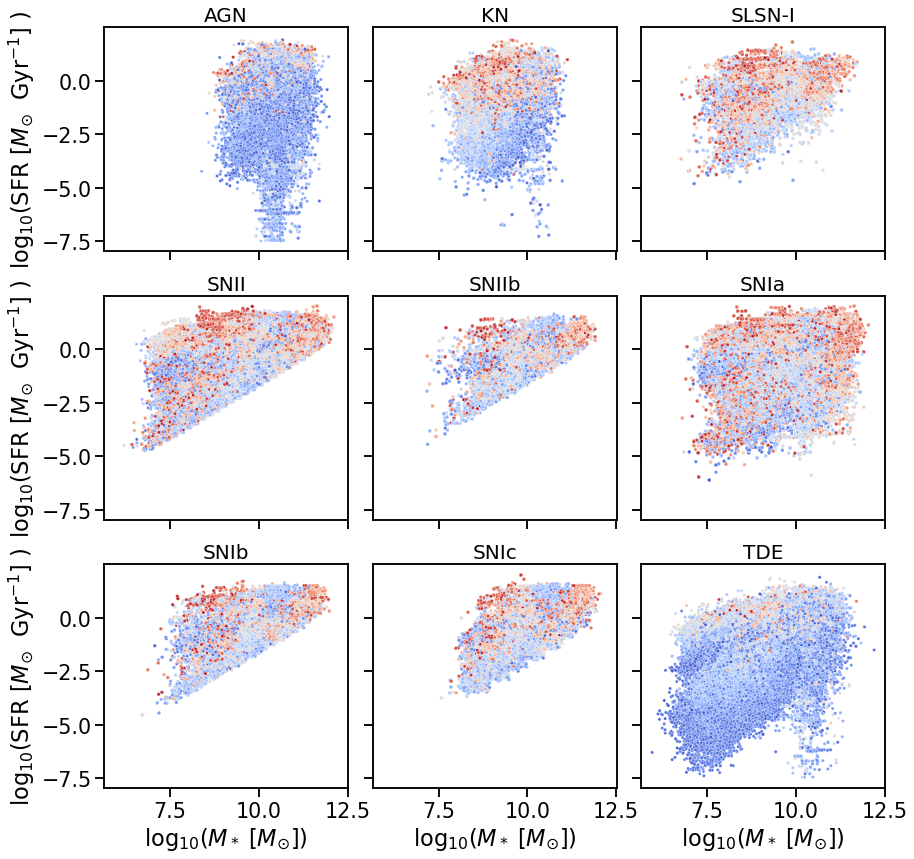

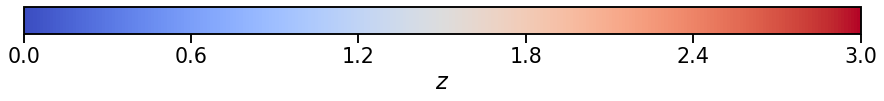

In [7]:
sns.set_context("talk",font_scale=1.25)
    
zmin = 0
zmax = 3

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 14), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)

for i in np.arange(len(scotch_hosts.keys())):
    transient = list(scotch_hosts.keys())[i]
    SFR = scotch_hosts[transient]['logSFR'][:] #host galaxy star-formation rate, in units of Msol/Gyr
    Mstar = scotch_hosts[transient]['logMstar'][:] #host galaxy stellar mass, in units of Msol
    z = scotch_hosts[transient]['z'][:] #true host galaxy redshift 
    ax = axs.ravel()[i]
    sns.scatterplot(x=Mstar, y=SFR, hue=z, palette='coolwarm', ax=ax, hue_norm=(zmin, zmax), legend=False, s=10)
    ax.set_title(transient, fontsize=20)
    ax.set_xlabel(r"log$_{10}(M_* \; [M_{\odot}])$")
    ax.set_ylabel(r"log$_{10}$(SFR [$M_{\odot} \;$ Gyr$^{-1}$] )")
    
fig, ax = plt.subplots(figsize=(15, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=zmin, vmax=zmax)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=np.linspace(zmin, zmax, 6))
cb1.set_label(r'$z$')

Because SCOTCH is a truth catalogue where all simulated events are observed, the redshift distribution for the classes above reflect the intrinsic rates used in the simulation and not realistic observed rates. 

Next, let's see how to snag individual light curves from the catalogue. 

## 2. Recovering Transient Light Curves

To do this, we'll need to switch over to the transient table. Let's start with one type of extragalactic transient: SNe II.

In [8]:
scotch_transients = scotch['TransientTable']

SNII = scotch_transients["SNII"]

We can now check what type-II SN models were run within SCOTCH.

In [9]:
print(SNII.keys())

<KeysViewHDF5 ['SNII+HostXT_V19', 'SNII-NMF', 'SNII-Templates', 'SNIIn+HostXT_V19', 'SNIIn-MOSFIT']>


More info on these models is provided in Lokken, Gagliano et al. 2022. Now let's plot the light curves of a single event for each SN II model.

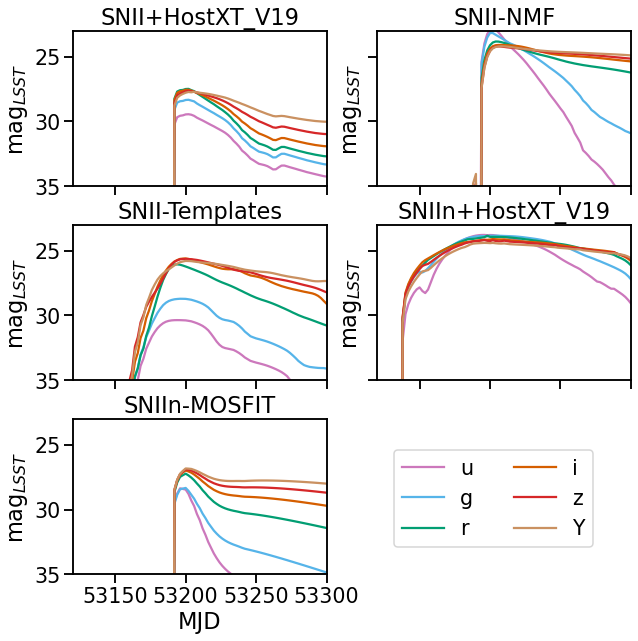

In [10]:
SNII_models = list(SNII.keys())

bands = 'ugrizY'
cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], 'tab:red', cols[7]], dtype='object') #u and y probably need changing

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        ax.plot(SNII_oneModel['MJD'][0], SNII_oneModel['mag_%s'%bands[j]][0], c=cols[j], label=bands[j])
    if i==0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

Because of the broad diversity of SNe II, this class contains the largest number of models of any transient class. Synthetic observations are taken with a ffixed 2.0 day cadence, as with nearly all other models in SCOTCH. The two exceptions are:

1. **AGN**: We include both a 2.0 day cadence set of light curves and a 0.2 day cadence set to study both the rapid and the broad photometric variations of the class, and 
2. **KN**: Kilonovae are highly valuable events scientifically, but are difficult to catch because of how red they are (due to the heavy elements produced in the event) and how faint they are. We choose a variable sampling cadence for these events to ensure that the peak is well-resolved. 

If another transient cadence is required (e.g. to match the properties of a particular survey) the light curve can be interpolated and re-sampled.

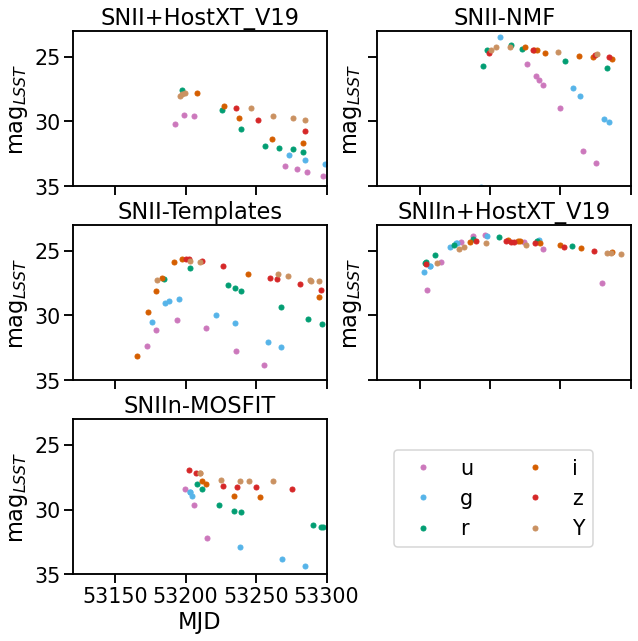

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        LC_MJD = SNII_oneModel['MJD'][0]
        LC_mag = SNII_oneModel['mag_%s'%bands[j]][0],
        f = interpolate.interp1d(LC_MJD, LC_mag)
        survey_MJD = np.random.uniform(low=53150, high=53300, size=8)
        survey_mag = f(survey_MJD)[0]
        ax.plot(survey_MJD, survey_mag, 'o', c=cols[j], label=bands[j], ms=5)
    if i==0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

Because these are true magnitudes, we need to post-process our light curves to account for extinction from Milky Way dust:

In [12]:
import extinction

#central passbands of LSST -- taken from http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=LSST&asttype=
wave = np.array([3694.25, 4840.83, 6257.74, 7563.60, 8718.83, 10142.41])

# Fitzpatrick (1999) extinction law
AV = 1.0
mags_ext = extinction.fitzpatrick99(wave, AV, 3.1)

Then, we can apply the extinction to our re-sampled light curves:

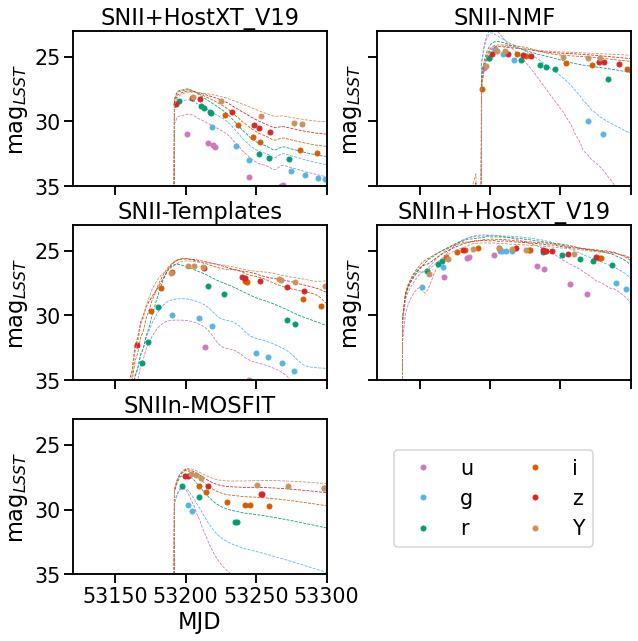

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        LC_MJD = SNII_oneModel['MJD'][0]
        LC_mag = SNII_oneModel['mag_%s'%bands[j]][0]
        f = interpolate.interp1d(LC_MJD, LC_mag)
        survey_MJD = np.random.uniform(low=53150, high=53300, size=8)
        survey_mag = f(survey_MJD)
        ax.plot(survey_MJD, survey_mag+mags_ext[j], 'o', c=cols[j], label=bands[j], ms=5)
        ax.plot(LC_MJD, LC_mag,'--',  c=cols[j], lw=0.8)
    if i==0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

Additional work is required to incorporate the noise properties of a survey.

## 3. Merging Transient and Host Properties

If we want to look at the properties of host galaxies and the properties of transients together, we can create pandas dataframes for each table and merge them. Let's start with 10,000 transients.

In [14]:
SNIa = {}
SNIa_hosts = {}

N = int(1.e4)

# first, create a pandas dataframe for the transient properties
for key in scotch_transients['SNIa']['SNIa-SALT2'].keys():
    if len(np.shape(scotch_transients['SNIa']['SNIa-SALT2'][key])) > 1:
        NLCs = np.arange(len(scotch_transients['SNIa']['SNIa-SALT2'][key][0:N+1, 0]))
        SNIa[key] = [list(scotch_transients['SNIa']['SNIa-SALT2'][key][i]) for i in NLCs]
    else:
        SNIa[key] = scotch_transients['SNIa']['SNIa-SALT2'][key][0:N+1]
SNIa_df = pd.DataFrame(SNIa)

# next, create a pandas dataframe for the host galaxy properties
for key in scotch_hosts['SNIa'].keys():
    SNIa_hosts[key] = scotch_hosts['SNIa'][key][:]           
SNIa_hosts_df = pd.DataFrame(SNIa_hosts)

# then merge them
SNIa_merged_df = SNIa_df.merge(SNIa_hosts_df, on=['TID', 'GID'], suffixes=('_transient', '_host'))
SNIa_merged_df.reset_index(inplace=True, drop=True)

The final catalogue will have the following properties:

In [15]:
print(SNIa_merged_df.columns.values)

['GID' 'MJD' 'TID' 'cadence' 'dec_off' 'mag_Y_transient' 'mag_g_transient'
 'mag_i_transient' 'mag_r_transient' 'mag_u_transient' 'mag_z_transient'
 'ra_off' 'sep' 'z_transient' 'a0' 'a1' 'a_rot' 'b0' 'b1' 'dc2ID' 'e' 'e0'
 'e1' 'logMstar' 'logSFR' 'mag_Y_host' 'mag_g_host' 'mag_i_host'
 'mag_r_host' 'mag_u_host' 'mag_z_host' 'magerr_Y' 'magerr_g' 'magerr_i'
 'magerr_r' 'magerr_u' 'magerr_z' 'n0' 'n1' 'w0' 'w1' 'z_host']


Now we can investigate correlations between the host galaxy and the transient. For example:

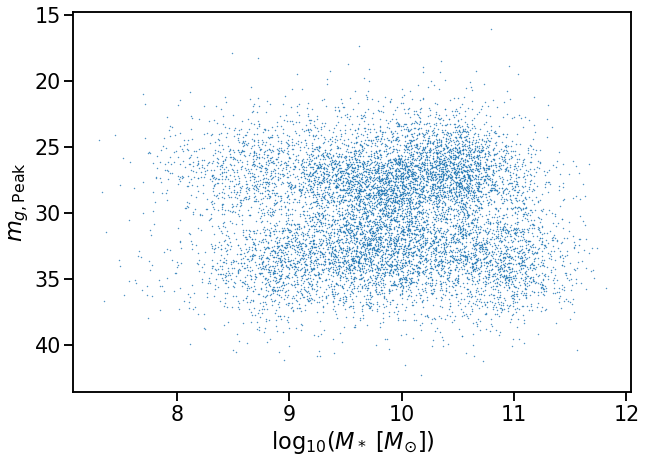

In [16]:
#get the peak magnitude in LSST g-band for each SNIa light curve
peakMag_g = [np.nanmin(x) for x in SNIa_merged_df['mag_g_transient']]

plt.figure(figsize=(10,7))
plt.plot(SNIa_merged_df['logMstar'], peakMag_g, 'o', ms=0.4)
plt.xlabel(r"log$_{10}(M_* \; [M_{\odot}])$")
plt.ylabel(r"$m_{g, \rm Peak}$");
plt.gca().invert_yaxis()

Here we see a mass step at $M_* = 10^{10}\; M_{\odot}$ in the $g$-band peak magnitudes of SNe Ia.  

## 4. Survey-Specific Analyses

SCOTCH is intended as a truth catalog, but for many purposes the goal is to simulate observations taken by real surveys with specific footprints and limited efficiency. We provide a (very simple) example of how to emulate the LSST Deep Drilling Field below, using PLAsTiCC data as a comparison.

This example requires the metadata from the test set of the PLAsTiCC challenge, which can be downloaded from https://zenodo.org/record/2539456#.YmHSu5LMKNF. 

In [17]:
plasticc = pd.read_csv("/Users/agagliano/Documents/Research/SCOTCH/data/plasticc/plasticc_test_metadata.csv")

#Model 90 is SNIa, and only consider SNe in the DDF
plasticc_SNIa = plasticc[(plasticc['true_target'] == 90) & (plasticc['ddf_bool'] == 1)]

#Model 42 is SNII
plasticc_SNII = plasticc[(plasticc['true_target'] == 42) & (plasticc['ddf_bool'] == 1)]

#Model 95 is SLSN-I
plasticc_SLSNI = plasticc[(plasticc['true_target'] == 95) & (plasticc['ddf_bool'] == 1)]

Now we loop through all our events, and cut the events that don't have at least 2 observations (in any band) above the 5-sigma DDF limit. 

In [18]:
#make cuts to align with the 5-sigma depths simulated for LSST DDF: 
fiveSigma = {'u':25.05, 'g':25.49, 'r':25.57, 'i':25.18, 'z':24.79, 'Y':23.84}

survey_models = [scotch_transients['SNIa']['SNIa-SALT2'], scotch_transients['SLSN-I']['SLSN-I']]
keep_models = []
for model in survey_models:
    keep_idxs = []
    for i in np.arange(len(model['MJD'][0:N+1, 0])):
        sigCount = 0
        for band in 'ugrizY':
            sigCount += np.nansum(np.array(model['mag_%s'%band][i, :]) < fiveSigma[band])
        if sigCount > 2:
            keep_idxs.append(i)
    keep_models.append(keep_idxs)

If we plot the redshift distributions of the events remaining after these cuts:

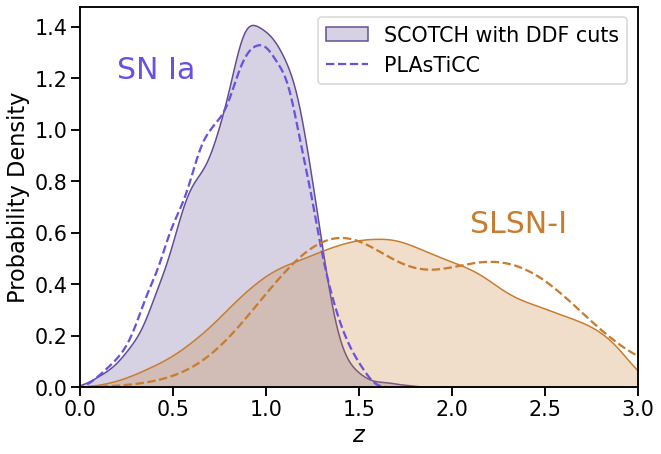

In [19]:
#purple -- 6951E1
#orange -- C77C30
plt.figure(figsize=(10,7))
sns.kdeplot(survey_models[0]['z'][keep_models[0]], shade=True, color='#634C93', label='SCOTCH with DDF cuts')
sns.kdeplot(survey_models[1]['z'][keep_models[1]], shade=True, color='#C77C30')
sns.kdeplot(plasticc_SNIa['true_z'], color='#6951E1', ls='--', label='PLAsTiCC')
sns.kdeplot(plasticc_SLSNI['true_z'],  color='#C77C30', ls='--')
plt.text(0.2, 1.2, "SN Ia", c='#6951E1', fontsize=30)
plt.text(2.1, 0.6, "SLSN-I", c='#C77C30', fontsize=30)
plt.legend()
plt.xlabel("$z$");
plt.ylabel("Probability Density");
plt.xlim((0, 3));
#plt.savefig("/Users/agagliano/Documents/Research/SCOTCH/published_transient_repo/transient-host-sims/plots/DDF_RedshiftDistribution.png",dpi=200,bbox_inches='tight')

Pretty good! The remaining discrepancy is caused by the fact that we don't consider Milky Way extinction in SCOTCH, and the fact that observational cuts in SNANA are done with an efficiency vs SNR curve, not a delta function like we've used here. 

If we want to place SNe within the DDF fields on the sky, we can use a library of simulated DDF observations to characterize the DDF footprint. This is in the repository under `data_files/PLASTICC_ORIGINAL_DDF.SIMLIB`. Let's snag the coordinates of the observations: 

In [20]:
ra_ddf = []
dec_ddf = []
nobs = []

df_set = []
with open("/Users/agagliano/Documents/Research/SCOTCH/data/PLASTICC_ORIGINAL_DDF.SIMLIB", "r") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith("RA"):
            coords = re.findall(r"[-+]?\d*\.*\d+", line)
            ra_ddf.append(float(coords[0]))
            dec_ddf.append(float(coords[1]))
            df_obs = pd.DataFrame({'RA':[float(coords[0])], 'Dec':[float(coords[1])]})
            df_set.append(df_obs)
df_full = pd.concat(df_set, ignore_index=True)

For simplicity, let's distinguish between the deep drilling fields and consider only one where we'd like to put our supernovae. 

In [21]:
df_full['DDF'] = 0
df_full.loc[np.abs(df_full['RA'] - 149) < 10, 'DDF'] = 1
df_full.loc[np.abs(df_full['RA'] - 30) < 10, 'DDF'] = 2
df_full.loc[np.abs(df_full['RA'] - 60) < 10, 'DDF'] = 3

Now we plot them as a sanity check:

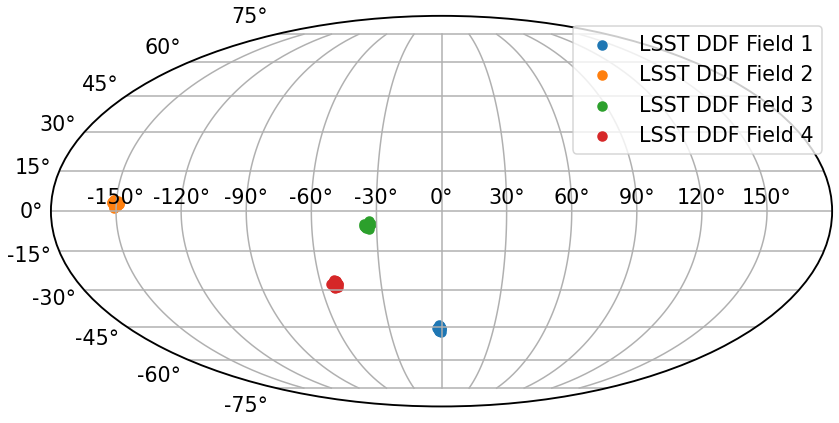

In [22]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection="mollweide")
for i in np.arange(len(np.unique(df_full['DDF']))):
    ddf = df_full[df_full['DDF'] == i]
    ra = coord.Angle(ddf['RA'], unit=u.deg)
    dec =  coord.Angle(ddf['Dec'], unit=u.deg)

    ax.scatter(-ra.radian, dec.radian, label='LSST DDF Field %i'%(i+1))
ax.grid(True)
plt.legend();

Great! We'll now use PZFlow to train a normalizing flow to understand the correlations between RA and DEC in one DDF, and sample the flow to generate new positions. These will be the locations of our transients on the sky.

Training 5000 epochs 
Loss:
(0) 2.7771
(1) 2.7466
(251) -0.1204
(501) -0.0702
(751) 0.3205
(1001) -0.3745
(1251) -0.5819
(1501) -0.3620
(1751) -0.7615
(2001) -0.7480
(2251) -0.5244
(2501) -0.5604
(2751) 0.0866
(3001) 0.0957
(3251) -0.0378
(3501) -0.3253
(3751) 0.2977
(4001) -0.0559
(4251) 0.2297
(4501) 0.0979
(4751) 0.0610
(5000) -0.7590


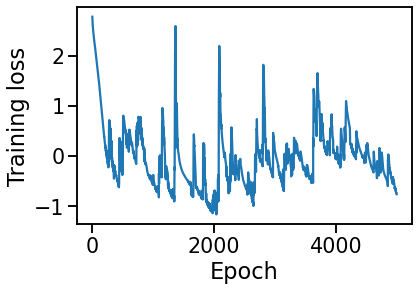

In [23]:
sample_set = []
for i in [2]:
    tempDF = df_full[df_full['DDF'] == i]
    flow = Flow(["RA", "Dec"])
    opt = optax.adam(1e-4)
    losses = flow.train(tempDF, optimizer=opt, epochs=5000, seed=0, verbose=True)

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.show()
    
    #generate locations for 4k transients in DDF 3
    samples = flow.sample(4000)
    samples['DDF'] = i
    sample_set.append(samples)
sample_df = pd.concat(sample_set)

A little jittery, but the loss values suggest that the model is well-trained. 

Now let's make sure that our re-sampled positions look reasonable: 

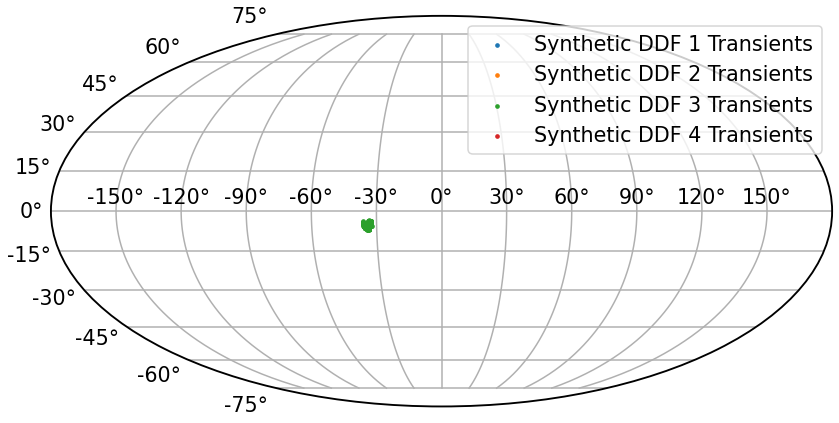

In [24]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection="mollweide")
for ddf in np.arange(4):
    sampled_ddf = sample_df[sample_df['DDF'] == ddf]
    ra = coord.Angle(sampled_ddf['RA'], unit=u.deg)
    dec =  coord.Angle(sampled_ddf['Dec'], unit=u.deg)

    ax.scatter(-ra.radian, dec.radian, label='Synthetic DDF %i Transients'%(ddf+1), s=10)
    ax.grid(True)
    plt.legend();

Beautiful! We'll pull the properties of transients and hosts and place the host galaxies of transients according to the offsets given in SCOTCH.

In [25]:
#Place 4k SNe Ia in DDF 3
#get the offsets and redshifts of galaxies and position them in the field
#TODO: Drop the zeros as soon as we get unique IDs!!
ddf2_transients = sample_df[sample_df['DDF'] == 2]
z = []
ra_off = []
dec_off = []

for TID in scotch_transients['SNIa']['SNIa-SALT2']['TID'][0:len(ddf2_transients)]:
    idx_transient = scotch_transients['SNIa']['SNIa-SALT2']['TID'][:] == TID
    idx_host = scotch_hosts['SNIa']['TID'][:] == TID
    z.append(scotch_hosts['SNIa']['z'][idx_host][0])
    ra_off.append(scotch_transients['SNIa']['SNIa-SALT2']['ra_off'][idx_transient][0])
    dec_off.append(scotch_transients['SNIa']['SNIa-SALT2']['ra_off'][idx_transient][0])  

In [26]:
#position the SNIa host galaxies within DDF 3
ddf2_transients['RA_off'] = ra_off
ddf2_transients['Dec_off'] = dec_off
ddf2_transients['z_host'] = z
ddf2_transients['RA_host'] = ddf2_transients['RA'] - ddf2_transients['RA_off']/3600.
ddf2_transients['Dec_host'] = ddf2_transients['Dec'] - ddf2_transients['Dec_off']/3600.

As a sanity check, we look at the distribution of angular offsets (in arcsec) of SNe Ia from their host galaxies: 

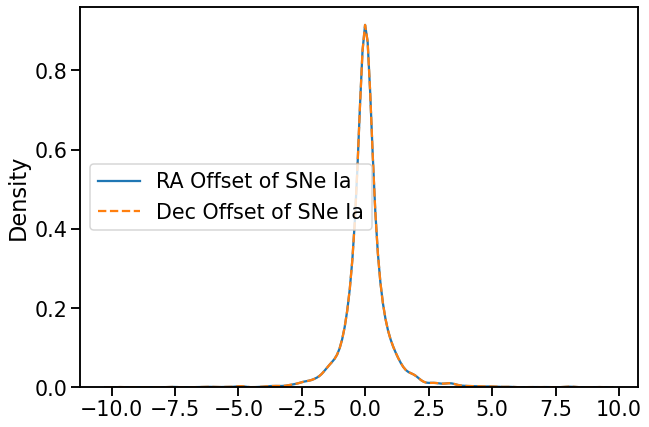

In [27]:
plt.figure(figsize=(10, 7))
sns.kdeplot(ra_off, label='RA Offset of SNe Ia')
sns.kdeplot(dec_off, label='Dec Offset of SNe Ia', ls='--')
plt.legend();

Let's now place the host galaxies in the DDF and color by their redshift: 

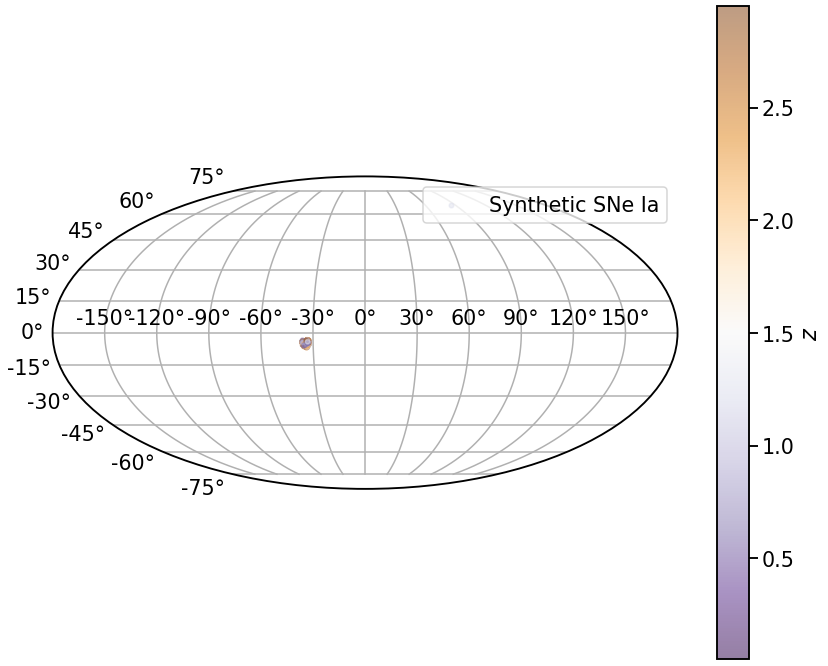

In [28]:
import cmasher as cmr
cmap = 'PuOr_r'

fig = plt.figure(figsize=(14,12))
ra = coord.Angle(ddf2_transients['RA_host'], unit=u.deg)
dec =  coord.Angle(ddf2_transients['Dec_host'], unit=u.deg)

ax = fig.add_subplot(111, projection="mollweide")
g = ax.scatter(-ra.radian, dec.radian, c=ddf2_transients['z_host'], cmap=cmap, label='Synthetic SNe Ia',alpha=0.5, s=20)
cbar = plt.colorbar(g)
cbar.set_label(r"$z$")
ax.grid(True)
plt.legend();
#plt.savefig("/Users/agagliano/Documents/Research/SCOTCH/published_transient_repo/transient-host-sims/plots/Mollweide_DDF_Simulated.png",dpi=200,bbox_inches='tight')

If we want a zoomed in view at where these galaxies are located: 

Text(0, 0.5, 'Dec. (deg)')

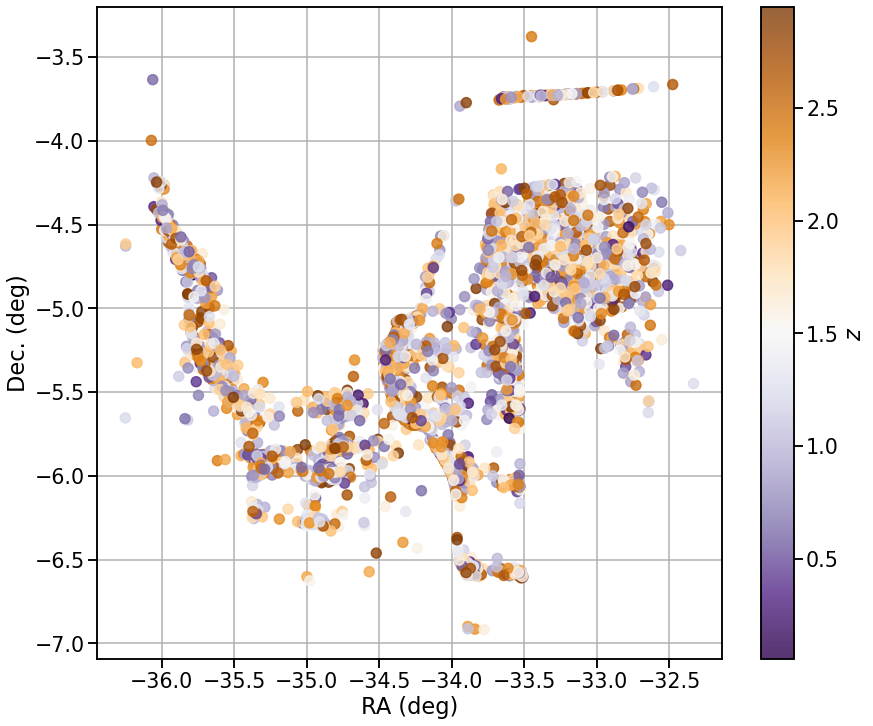

In [29]:
fig = plt.figure(figsize=(14,12))
ra = coord.Angle(ddf2_transients['RA_host'], unit=u.deg)
dec =  coord.Angle(ddf2_transients['Dec_host'], unit=u.deg)
g = plt.scatter(-ra.deg, dec.deg, c=ddf2_transients['z_host'], cmap=cmap,  s=100,alpha=0.8, zorder=100)
cbar = plt.colorbar(g)
cbar.set_label(r"$z$")
plt.grid(True)
plt.xlabel("RA (deg)")
plt.ylabel("Dec. (deg)")
#plt.savefig("/Users/agagliano/Documents/Research/SCOTCH/published_transient_repo/transient-host-sims/plots/DDF_ZoomIn.png",dpi=200,bbox_inches='tight')

And, comparing that with the observations already in the simlib:

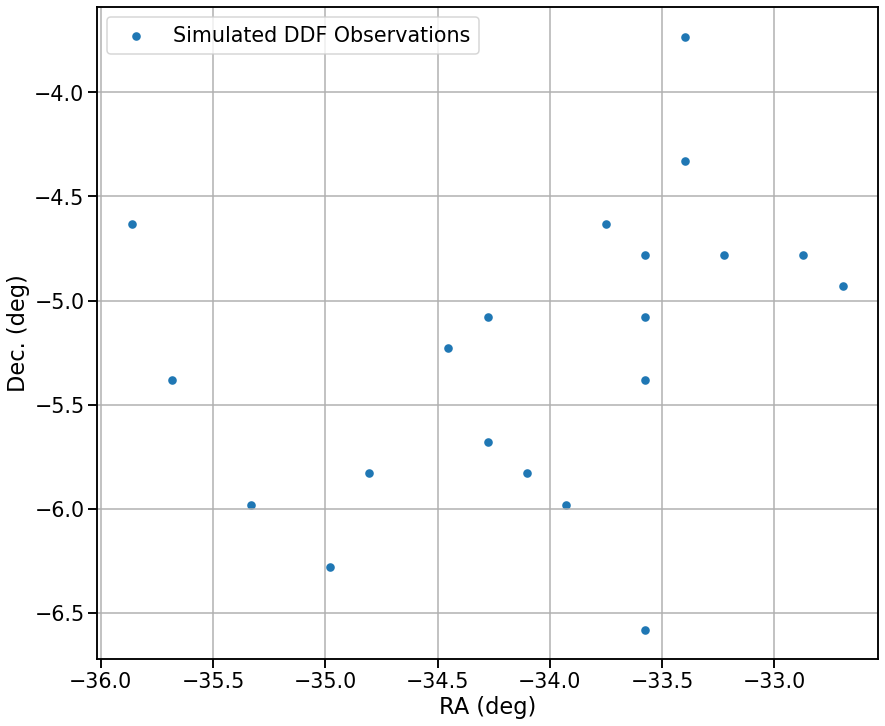

In [30]:
ddf2 = df_full[df_full['DDF'] == 2]

fig = plt.figure(figsize=(14,12))
ra = coord.Angle(ddf2['RA'], unit=u.deg)
dec =  coord.Angle(ddf2['Dec'], unit=u.deg)
g = plt.scatter(-ra.deg, dec.deg, cmap='coolwarm', label='Simulated DDF Observations', s=50)
plt.grid(True)
plt.xlabel("RA (deg)")
plt.ylabel("Dec. (deg)")
plt.legend();

We see that our normalizing flow generated a lot of structure in between the observations in the `DDF_SIMLIB` that we used. There are many parameters in PZFlow that can be tweaked to construct a smoother flow, but sometimes this structure is desired (as in the case of Large Scale Structure simulations within which you'd like to embed transients). We suggest a deep dive into the beautiful documentation over at https://jfcrenshaw.github.io/pzflow/tutorials/ to learn more about how to fine-tune a normalizing flow for your science case.